In [14]:
using Pandas
using DataFrames
using PyCall
using PyPlot
using Plots
using CSV
using LsqFit
using Printf
using KernelDensity
using Distributions

include("tacos.jl") # Tools to Analyse Components Systems

scipy_integrate = pyimport("scipy.integrate")
scipy_stats = pyimport("scipy.stats")
pushfirst!(PyVector(pyimport("sys")."path"), "")
frontiers = pyimport("frontiers_colors");

# Global Zipf 

In [ ]:
f_gtex = CSV.read("A_gtex.dat", header=true).abundance
f_gtex = sort(f_gtex./sum(f_gtex), rev=true);

In [ ]:
f_mca = Tacos.load_pickle("mca/data_all.pkl")["freq"]
f_mca = sort(f_mca./sum(f_mca), rev=true);

In [ ]:
f_tm = Tacos.load_pickle("tm/data_all.pkl")["freq"]
f_tm = sort(f_tm./sum(f_tm), rev=true);

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

X = collect(1:1e5)

ax.plot(X,[1e-1*x^-0.8 for x in X], lw=20, ls="--", color="gray")

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)


ax.annotate(L"$k*i^{-0.8}$", (1e2,1e-2), fontsize=35)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets.pdf")

## Fit ranges

In [100]:
fit_func = function(X, p)
    return p[1]*[x^(-p[2]) for x in X]
end

fit_func_exp = function(X, p)
    return p[1]*[exp(-p[2]*x) for x in X]
end

#123 (generic function with 1 method)

In [99]:
bounds = Dict()

bounds["dx"] = Dict()
bounds["sx"] = Dict()

bounds["sx"]["min"]=2
bounds["sx"]["max"]=122
bounds["sx"]["step"]=10

bounds["dx"]["min"]=5e2
bounds["dx"]["max"]=2e4
bounds["dx"]["step"]=100

optimize_fit = function(f)
    maxmimum_r2 = -Inf
    optimal_fit = nothing
    optimal_limits = nothing
    fit_exp = nothing
    
    Rs = zeros(Float64, Int64((bounds["sx"]["max"]- bounds["sx"]["min"])/ bounds["sx"]["step"]+1), Int64(( bounds["dx"]["max"]- bounds["dx"]["min"])/ bounds["dx"]["step"]+1))
    for left_side::Int32=range(bounds["sx"]["min"],bounds["sx"]["max"],step=bounds["sx"]["step"]), right_side::Int32=range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"])
        #println(left_side," ", right_side)
        
        x_data = left_side:right_side
        y_data = f[left_side:right_side]
        fit = curve_fit(fit_func, x_data, y_data, [1e-1, 0.8])
        popt, pcov = (coef(fit), estimate_covar(fit))
        r_squared = Tacos.estimate_r2(fit_func, popt, x_data, y_data)
        Rs[Int64((left_side-bounds["sx"]["min"])/bounds["sx"]["step"]+1),Int64((right_side-bounds["dx"]["min"])/bounds["dx"]["step"]+1)]=r_squared
        if r_squared > maxmimum_r2
            maxmimum_r2 = r_squared
            optimal_fit = fit
            optimal_limits = (left_side, right_side)
        end    
    end
    return maxmimum_r2, optimal_fit, optimal_limits, Rs, bounds
end

#117 (generic function with 1 method)

In [ ]:
r2, fit,  limits, Rs, windows = optimize_fit(f_gtex);

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

popt = coef(fit)

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

X = collect(1:1e5)

#ax.plot(X,[1e-1*x^-0.8 for x in X], ls="--", color="gray")
ax.plot(X,[popt[1]*x^-popt[2] for x in X], ls=":", lw=5, color="green", label="$(@sprintf("%.2f", popt[1]))*x^-$(@sprintf("%.2f", popt[2]))")

#ax.annotate(L"$k*i^{-0.8}$", (1e2,1e-2), fontsize=22)
ax.annotate("R^2=$(@sprintf("%.4f", r2))", (10^((log10(limits[1])+log10(limits[2]))/2),1e-6), fontsize=35)

ax.vlines([limits[1] limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=15, alpha =0.5)
ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)


ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets_fit_gtex.pdf")

In [ ]:
CSV.write("rs_gtex.csv", DataFrames.DataFrame(Rs))

In [ ]:
fig,ax = PyPlot.subplots(1, 2, figsize=(18,8))

for (dataset, limits, sx_max, color) in zip(["tm", "mca", "gtex"],[(12,1000); (72,4100); (62,5100)],[82 122 122], ["red" "blue" "gray"])
    Rs = Matrix(CSV.read("rs_$(dataset).csv"))
    ax[1].plot(range(bounds["sx"]["min"],sx_max,step=bounds["sx"]["step"]), Rs[:,Int64((limits[2]-bounds["dx"]["min"])/bounds["dx"]["step"]+1)], lw=15, color=color)
    ax[2].plot(range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"]), Rs[Int64((limits[1]-bounds["sx"]["min"])/bounds["sx"]["step"]+1),:], lw=15, color=color)
        
    ax[1].vlines([limits[1]], 0.95, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    ax[2].vlines([limits[2]], 0.98, 1, colors=color, ls="-.", lw=10, alpha =0.5)
end

ax[1].set_ylabel(L"R^2", fontsize=35)
ax[1].set_xlabel("left bound", fontsize=35)
#ax[1].set_xscale("log")

ax[2].set_xlabel("right bound", fontsize=35)
#ax[2].set_xscale("log")

ax[1].tick_params(axis="x", rotation=10)
ax[2].tick_params(axis="x", rotation=10)
#ax[2].set_ylim(0.98,0.999)

PyPlot.show()
fig.savefig("bounds.pdf")

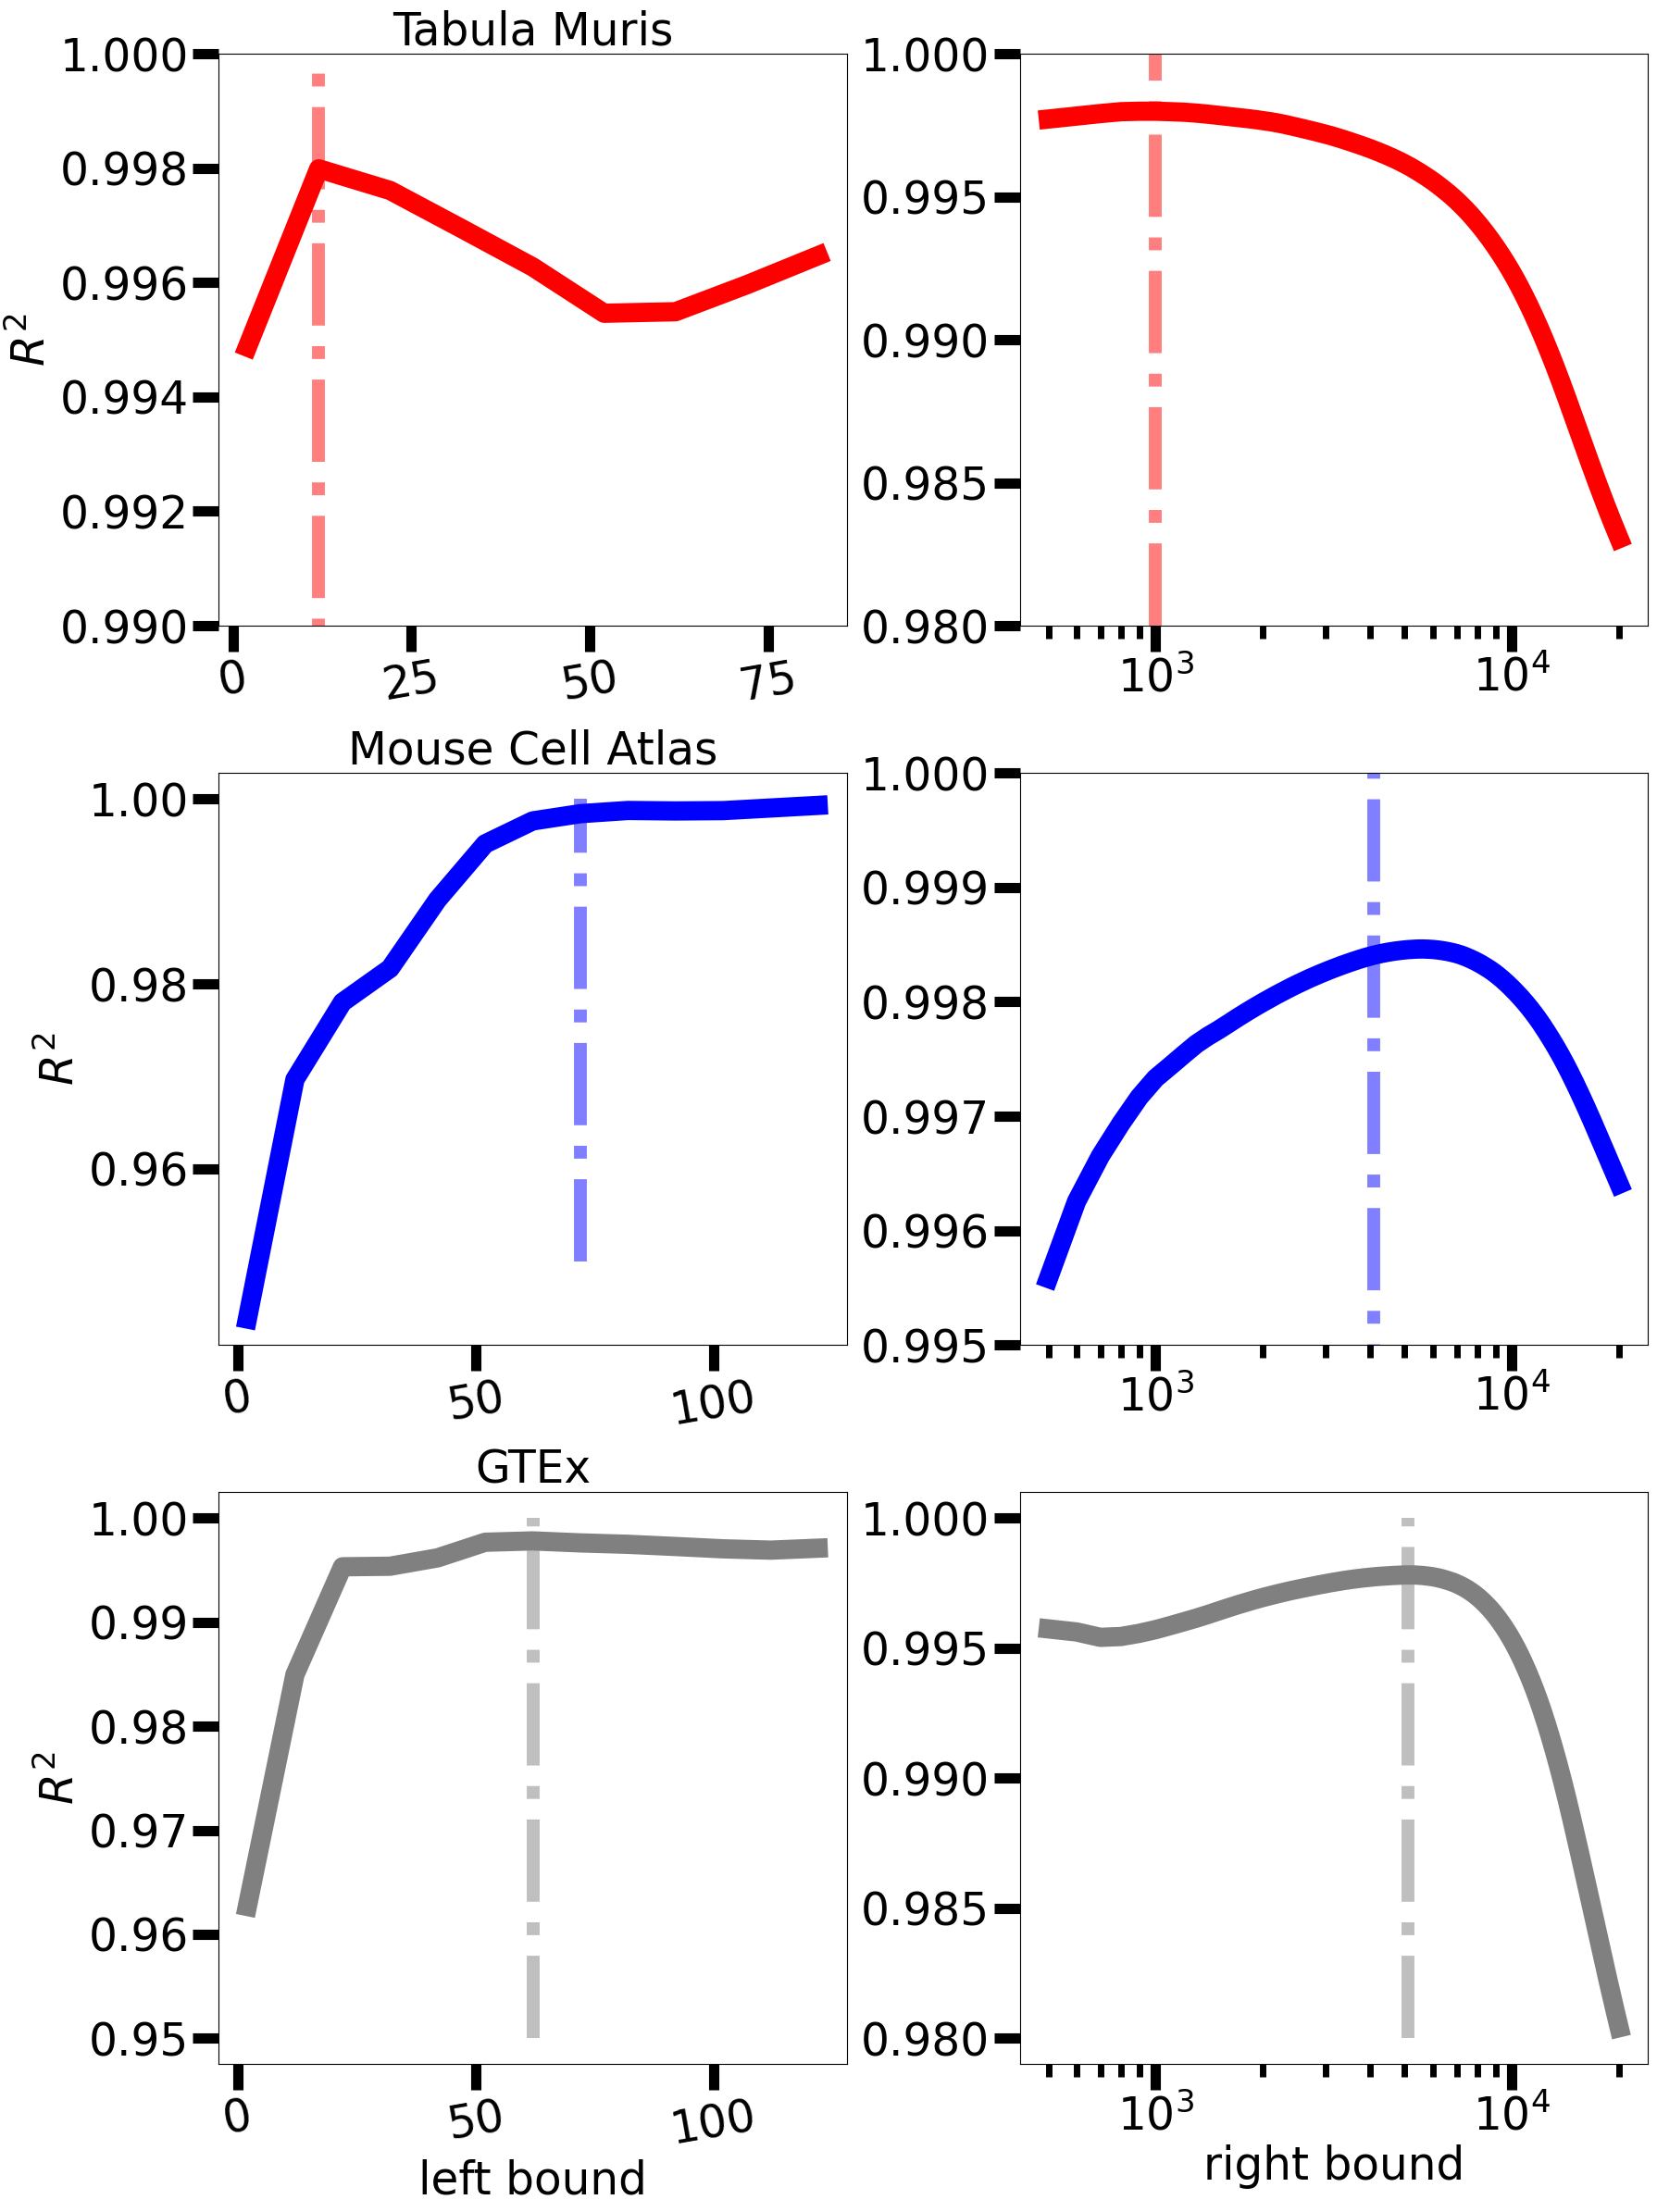

In [103]:
fig,ax = PyPlot.subplots(3, 2, figsize=(18,24))

for ((idataset,dataset), limits, sx_max, color) in zip(enumerate(["tm", "mca", "gtex"]),[(12,1000); (72,4100); (62,5100)],[82 122 122], ["red" "blue" "gray"])
    Rs = Matrix(CSV.read("rs_$(dataset).csv"))
    
    lax = idataset
    rax= idataset+3
    
    ax[lax].plot(range(bounds["sx"]["min"],sx_max,step=bounds["sx"]["step"]), Rs[:,Int64((limits[2]-bounds["dx"]["min"])/bounds["dx"]["step"]+1)], lw=15, color=color)
    ax[rax].plot(range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"]), Rs[Int64((limits[1]-bounds["sx"]["min"])/bounds["sx"]["step"]+1),:], lw=15, color=color)
    
    ax[lax].vlines([limits[1]], 0.95, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    ax[rax].vlines([limits[2]], 0.98, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    
    ax[lax].set_ylabel(L"R^2", fontsize=35)

    ax[rax].set_xscale("log")
    
    ax[lax].tick_params(axis="x", rotation=10)
    ax[lax].tick_params(axis="x", rotation=10)
    
    ax[lax].tick_params(labelsize=35, width=8, length=20)
    ax[lax].tick_params(axis="both", which="minor", width=5, length=10)
    
    ax[rax].tick_params(labelsize=35, width=8, length=20)
    ax[rax].tick_params(axis="both", which="minor", width=5, length=10)

end

ax[3].set_xlabel("left bound", fontsize=35)
ax[6].set_xlabel("right bound", fontsize=35)

ax[1].set_title("Tabula Muris", fontsize=35)
ax[2].set_title("Mouse Cell Atlas", fontsize=35)
ax[3].set_title("GTEx", fontsize=35)


ax[1].set_ylim(0.99,1)
ax[4].set_ylim(0.98,1)
ax[5].set_ylim(0.9950,1)


PyPlot.show()
fig.savefig("bounds_panel.pdf")

In [ ]:
limits = (Int64(round(mean([12 72 62]))), Int64(round(mean([1000 4100 5100])))) #tm mca gtex

fig, ax = PyPlot.subplots(figsize=(18,15))

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

X = collect(1:1e5)

ax.vlines([limits[1] limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=15, alpha =0.5)
ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets_fit_avg.pdf")

### Save first regime for GO

In [ ]:
first_regime = DataFrames.DataFrame()
first_regime.mca = sort(CSV.read("A_mca.dat"), 2, rev=true).Column1[1:limits[1]]
first_regime.tm = sort(CSV.read("A_tm.dat"), 2, rev=true).Column1[1:limits[1]]
first_regime.gtex = sort(CSV.read("A_gtex.dat"), 2, rev=true).ensg[1:limits[1]]
CSV.write("first_regime.csv",first_regime)

# Global scaling

## Var vs Mean

In [ ]:
data_source = "mca"
data = Tacos.load_pickle("$(data_source)/data_all.pkl");

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

ax.scatter(data["means"], data["var"], c="gray", s=225, alpha=0.3, label="data")

x = range(1e-5,10, length=10)
ax.plot(x,x, lw=5, color="red", ls="--", label=L"$m_g$ (Poisson)")

x = range(0.5,5e5, length=10)
ax.plot(x,[x_i^2 for x_i in x], lw=5, color="blue", ls="--", label=L"$m_g^2$ (Taylor)")

ax.set_xlabel(L"Mean expression level, $m_g$", fontsize=35)
ax.set_ylabel(L"Variance of expression level, $v_g$", fontsize=35)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1e-5, data["means"].max()*1.5)
ax.set_ylim(1e-6, data["var"].max()*1.5)

ax.legend(fontsize=35)

PyPlot.show()
fig.savefig("var_mean_$(data_source).pdf")

## CV2 mean

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

means = [m for (m,v) in zip(data["means"], data["var"]) if v>1e-6]
vars = [v for v in data["var"] if v>1e-6]

ax.scatter(means, [v/m/m for (m,v) in zip(means, vars)], c="gray", alpha=0.3, s=225, label="data")

x = range(1e-5,10, length=10)
ax.plot(x,[1/x_i for x_i in x], lw=5, color="red", ls="--", label=L"$m_g^{-1}$ (Poisson)")

x = range(0.5,5e5, length=10)
ax.plot(x,[1 for _ in x], lw=5, color="blue", ls="--", label=L"$1$ (Taylor)")

ax.set_ylabel(L"Coefficient of variation squared, $CV^2_g$", fontsize=35)
ax.set_xlabel(L"Mean expression level, $m_g$", fontsize=35)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1e-5, maximum(means)*1.5)
ax.set_ylim(5e-2, 1e5)

ax.legend(fontsize=35)

PyPlot.show()
fig.savefig("cv2_mean_$(data_source).pdf")

# Histogram of all data

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

data_source= "mca"
n_bins=35

bin_counts=zeros(n_bins)
bin_edges = zeros(n_bins+1)

bin_pdf = zeros(n_bins)

for tissue in [f for f in readdir("$(data_source)") if occursin("mainTable",f)]
    println(tissue)
    if occursin("Marrow.csv", tissue)
        continue
    end
    df = CSV.read("$(data_source)/$(tissue)");
    df_values = convert(Array, select!(df,Not(1)));
    #df_values=df_values./sum(df_values, dims = 1)
    df_values = reshape(df_values,1,size(df_values)[1]*size(df_values)[2])
    df_values = df_values[df_values.>0]
    x=[log2(dge) for dge in df_values];
    bc, be = ax.hist(x, lw=10, histtype="step", density=false, bins = n_bins)
    bin_counts+=bc
    x_bins = (be[2:length(be)] + be[1:length(be)-1])/2
    bin_pdf += pdf(kde(x), x_bins)
    bin_edges=be
end
GC.gc()

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))


#bin_count, bin_edges = ax.hist(x, lw=10, histtype="step", density=true, bins = 20)

x_bins = (bin_edges[2:length(bin_edges)]+ bin_edges[1:length(bin_edges)-1])/2

rang = 2:n_bins
ax.hist(bin_edges[2:length(bin_edges)-1], bins=bin_edges[2:length(bin_edges)-1], weights=bin_counts[rang] / sum(bin_counts[rang]), histtype="step", lw=15, alpha=0.8, label="data")

ax.plot(x_bins[rang], bin_pdf[rang] / sum(bin_pdf[rang]), lw=15, alpha=0.6, label="KDE")

ax.set_xlabel("Log2(UMI)", fontsize=35)
ax.set_ylabel("Probability density function", fontsize=35)

#ax.set_yscale("log")

ax.legend(fontsize=35)
PyPlot.show()

fig.savefig("all_hist_$(data_source).pdf")
fig.savefig("all_hist_$(data_source).png", dpi=400)

# Pdf of Frequencies

In [16]:
data = Tacos.load_pickle("mca/data_all.pkl")

Dict{Any,Any} with 12 entries:
  "cell_zeros"    => PyObject EmbryonicMesenchyme_1.AAAACGAAGTACGGGTTT    19424…
  "O"             => PyObject 00R_AC107638.2    0.000180…
  "diffWords"     => PyObject EmbryonicMesenchyme_1.AAAACGAAGTACGGGTTT     395…
  "M"             => PyObject EmbryonicMesenchyme_1.AAAACGAAGTACGGGTTT     599.…
  "n_expressed"   => PyObject 00R_AC107638.2    0…
  "means_nonzero" => PyObject 00R_AC107638.2    1.000000…
  "var"           => PyObject 00R_AC107638.2    0.000180…
  "n_genes"       => Dict{Any,Any}("MammaryGland.Virgin"=>PyObject MammaryGland…
  "freq"          => PyObject 00R_AC107638.2    6.684696e-08…
  "cv2"           => PyObject 00R_AC107638.2    5563.666667…
  "frac_of"       => Dict{Any,Any}("MammaryGland.Virgin"=>Dict{Any,Any}("N"=>13…
  "means"         => PyObject 00R_AC107638.2    0.000180…

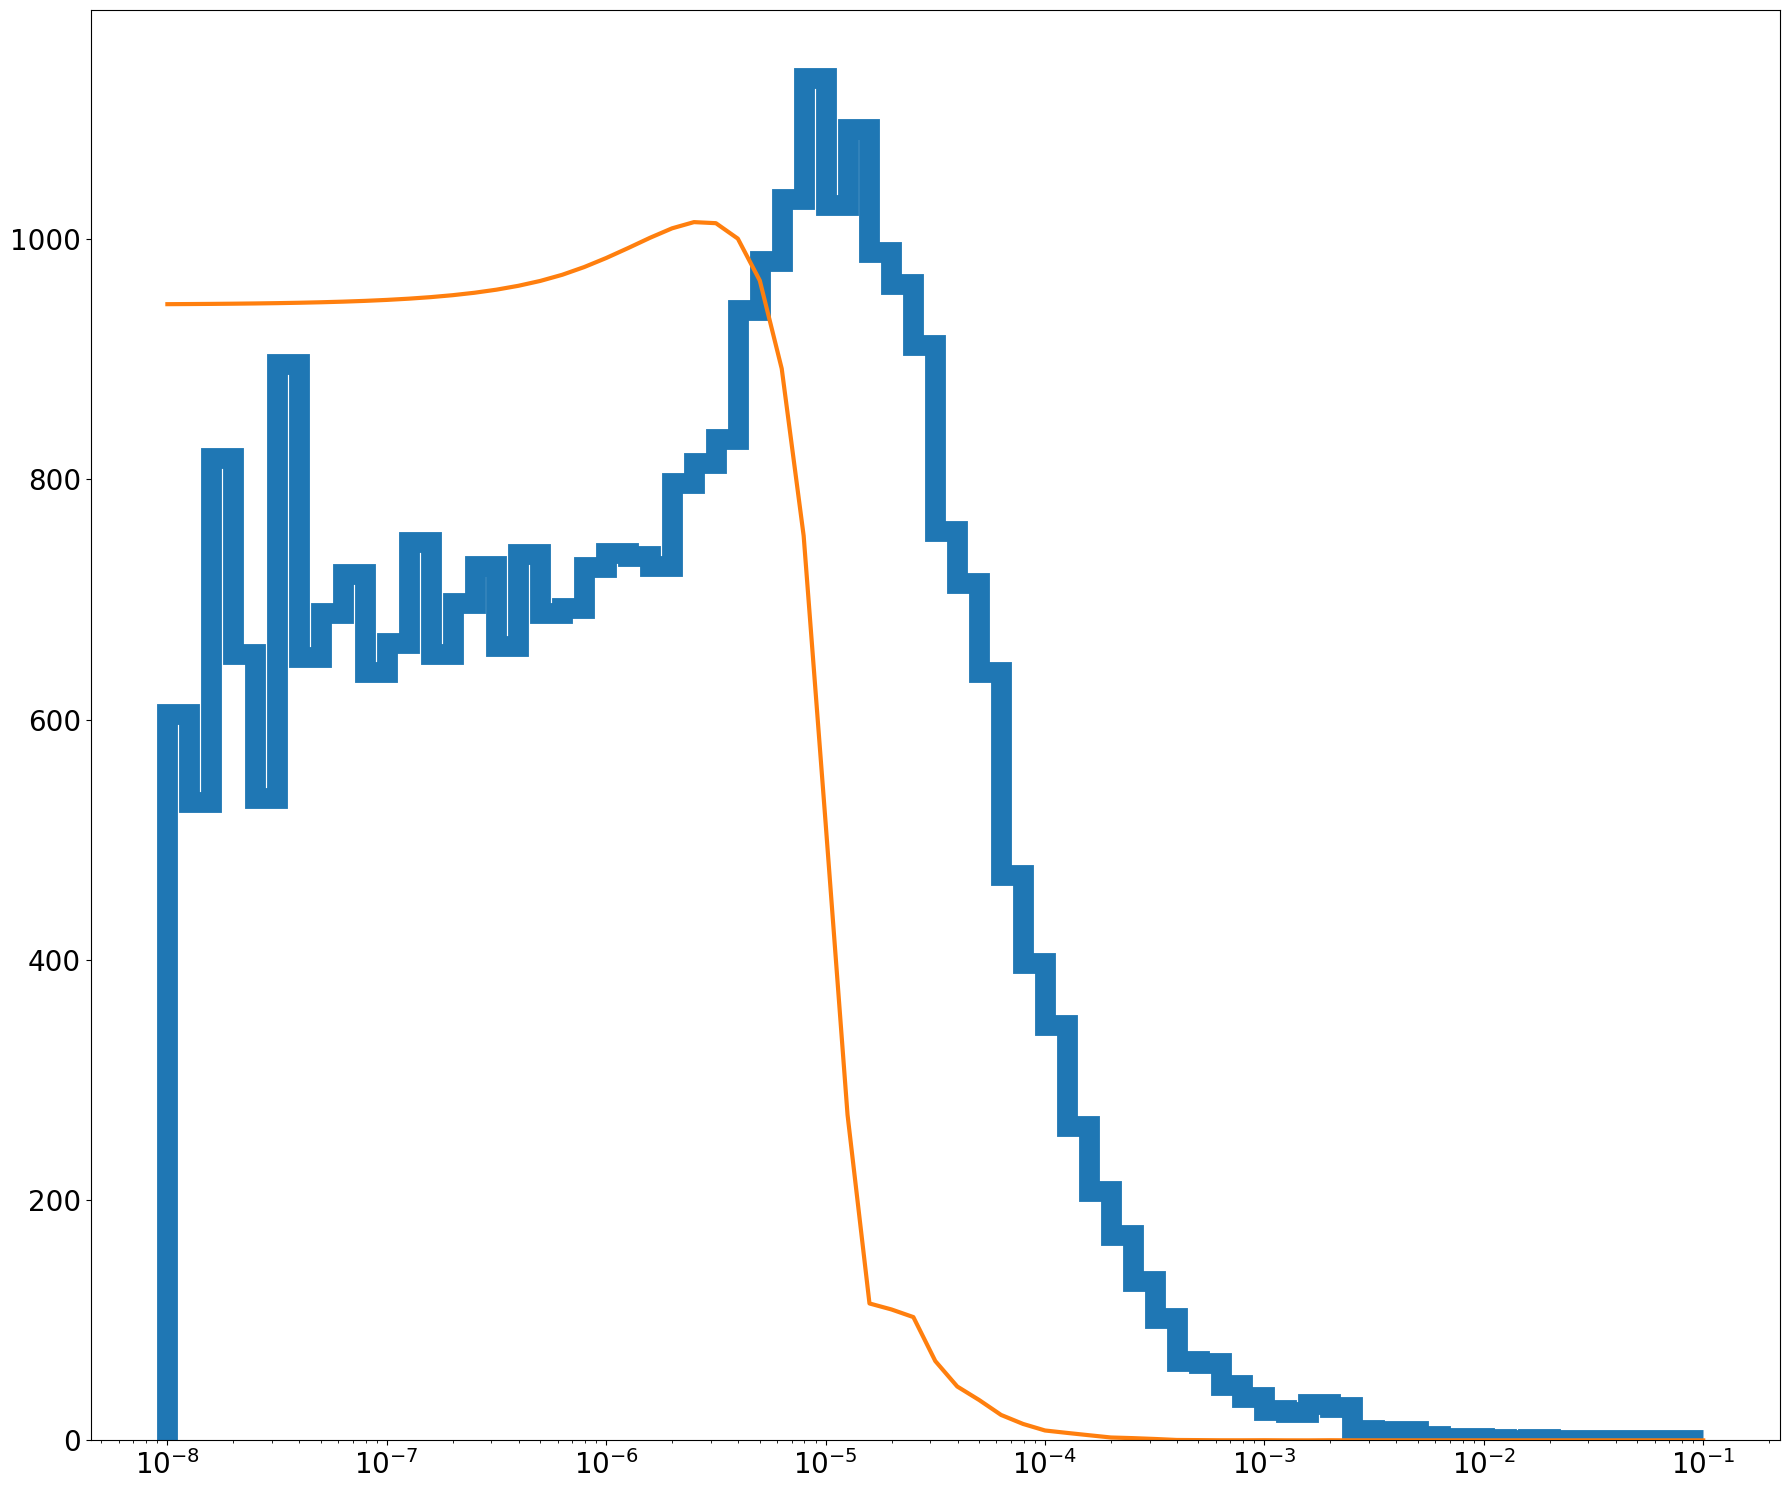

In [94]:
fig, ax = PyPlot.subplots(figsize=(18,15))

f = data["freq"].values
f = f[f .> 0]
 
x_bins = sort!([10. ^ -x for x in 1:0.1:8])
bin_counts, bin_edges = ax.hist(f, bins=x_bins, density=false, histtype="step", lw=15)

kde_values = pdf(kde(f), x_bins)
ax.plot(x_bins,kde_values/sum(kde_values)*30000)

ax.set_xscale("log")


PyPlot.show()

# UMI count histogram

In [ ]:
data = Tacos.load_pickle("mca/data_Bone-Marrow_c-kit_data.pkl");

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

bin_counts, bin_edges = ax.hist(data["M"], density=true, color="blue", histtype="step", lw=10, bins=100)

m = mean(data["M"])
ax.vlines([m], 0,1e-3, lw=15, alpha=0.8,  ls="-.")
ax.annotate("Average: $(@sprintf("%.0f", m))", (m*1.1,5e-4), fontsize=35)

m = median(data["M"])
ax.vlines([m], 0,2e-3, lw=15, alpha=0.8,  ls="-.")
ax.annotate("Median: $(@sprintf("%.0f", m))", (m*1.1,10e-4), fontsize=35)

x_bins=(bin_edges[1:100]+bin_edges[2:101])/2

scaled_pois = function(X, par)
    mu = par[1]
    C = par[2]
    a = par[3]
    d = Poisson(mu)
    return C*[pdf(d,round(Int, x/a::Float64)) for x in X]
end

fit_pois = curve_fit(scaled_pois, x_bins, bin_counts, [0.5, 0.1, 1000])
popt = coef(fit_pois)
println(popt)

ax.plot(x_bins, scaled_pois(x_bins, popt), lw=10, color="orange")

ax.set_xlabel(L"Reads per cell, $M$", fontsize=35)
ax.set_ylabel("Probability density function", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)

#ax.set_xscale("log")
#ax.set_yscale("log")

#ax.set_xlim(1,3e8)

#ax.legend(fontsize=22)

PyPlot.show()
fig.savefig("M_hist_mca.pdf")

In [ ]:
M = transpose(data["M"].values)
quantiles = quantile(transpose(M), range(0,1, length=5))

for q in range(2,length(quantiles), step=1) 
    print(quantiles[q-1], " - ", quantiles[q], ": ")
    println(mean(filter(m -> (m.>quantiles[q-1]) & (m.<quantiles[q]), M)))
end

# Heaps' integral

In [ ]:
integrals = []
used_tissues = []
tissues = (split(split(f,"data_")[2],"_data")[1] for f in readdir("mca") if occursin(".pkl",f) && !occursin("mazzolini",f) && !occursin("data_all.pkl",f))

function fit_func(x,a,b)
    return a*x^b
end

for tissue in tissues
    println(tissue)
    integral=load_pickle("mca/data_$(tissue)_data.pkl")["heaps_integral"][1]
    params = load_pickle("mca/data_$(tissue)_data.pkl")["heaps_fit"]
    integral=scipy_integrate.quad(fit_func, 500, 1000, args=(params[1], params[2]))[1]
    append!(integrals, integral::Float64)
end
integrals = DataFrames.DataFrame(data=integrals, index = collect(tissues))
sort!(integrals, rev=true)

In [ ]:
CSV.write("integral_heaps.csv", integrals)

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))
for (itissue, tissue) in enumerate(integrals.index)
    ax.plot(itissue, integrals[itissue,1], marker="o", c=frontiers.get_color(tissue), lw=0, ms=15)
end
locs, labels = xticks()
ax.set_xticks(0:length(integrals.index))
ax.set_xticklabels(rotation=90, labels = integrals.index)

ax.set_ylabel("Heaps' integral", fontsize=35)

ax.tick_params(labelsize=25, width=8, length=20)

fig.savefig("itegral_heapfs_scatter_plot_mca.pdf")
fig.savefig("itegral_heapfs_scatter_plot_mca.png")

In [ ]:
CSV.write("integral.csv", integrals)

In [ ]:
integrals.rank=1:length(integrals.index)

In [ ]:
mca_tm

In [ ]:
mca_tm = CSV.read("integral.csv")
select!(mca_tm,Not(:GTex))
mca_tm = DataFrames.dropmissing(mca_tm)
sort!(mca_tm,:TM)
mca_tm.TM = 1:11
sort!(mca_tm,:MCA)
mca_tm.MCA = 1:11
sort!(mca_tm, :MCA)

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))
ax.scatter(mca_tm.MCA, mca_tm.TM, c="gray", s=2500)
ax.set_xlabel("MCA integral's rank", fontsize=35)
ax.set_ylabel("TM integral's rank", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)


fig.savefig("heaps_rank_both.pdf")
fig.savefig("heaps_rank_both.svg")

# Analyse single organ

In [8]:
tissue = "Bone-Marrow_c-kit"

data = Dict()
data["data"]=Tacos.load_pickle("mca/data_$(tissue)_data.pkl")
data["mazzolini"]=Tacos.load_pickle("mca/data_$(tissue)_mazzolini.pkl")
#data["null_1"]=load_pickle("data_$(tissue)_null_1.pkl")

Dict{Any,Any} with 10 entries:
  "var"            => PyObject 00R_AC107638.2    0.000006…
  "O"              => PyObject 00R_AC107638.2    0.000151…
  "diffWords"      => PyObject BoneMarrowcKit_3.TTTAGGTTGGACCATCCC    2061…
  "heaps_integral" => (4.46935e7, 0.0634182)
  "M"              => PyObject BoneMarrowcKit_3.TTTAGGTTGGACCATCCC    1116.0…
  "means_nonzero"  => PyObject 00R_AC107638.2    0.200000…
  "heaps_fit"      => [54.5662, 0.5253]
  "freq"           => PyObject 00R_AC107638.2    2.045183e-08…
  "cv2"            => PyObject 00R_AC107638.2    6619.750000…
  "means"          => PyObject 00R_AC107638.2    0.000030…

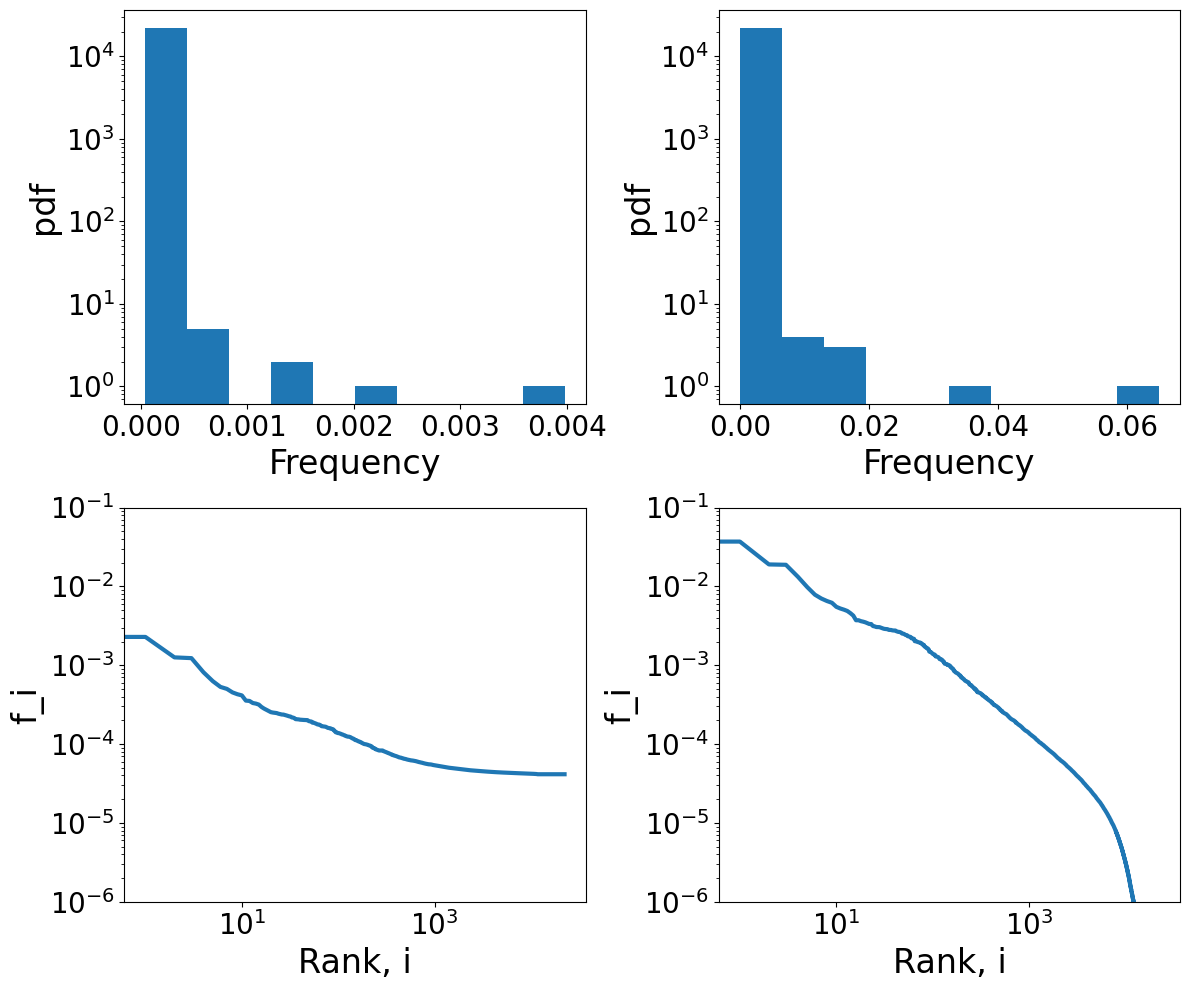

In [9]:
fig, ax = subplots(2,2, figsize=(12,10))
f = data["data"]["means_nonzero"].sort_values(ascending=false)

ax[1].hist(f/f.sum(),  bins=10)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_ylim(1e-6,1e-1)
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)


f = data["data"]["means"].sort_values(ascending=false)

ax[3].hist(f/f.sum(), bins=10)
ax[3].set_yscale("log")
ax[3].set_xlabel("Frequency", fontsize=24)
ax[3].set_ylabel("pdf", fontsize=24)

ax[4].plot(f/f.sum())
ax[4].set_xscale("log")
ax[4].set_yscale("log")
ax[4].set_ylim(1e-6,1e-1)
ax[4].set_xlabel("Rank, i", fontsize=24)
ax[4].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

In [ ]:
bins=10
rang = (0-0.5/bins, 1+0.5/bins)
fig, ax = subplots(1,2, figsize=(10,5))

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, ls="--", label="mazzolini")

ax[1].legend(fontsize=20)
ax[1].set_xlabel("O_i")

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, ls="--", label="mazzolini")

ax[2].set_yscale("log")
ax[2].legend(fontsize=20)
ax[2].set_xlabel("O_i")

fig.savefig("null_U.pdf")

In [ ]:
fig, ax = PyPlot.subplots()

function fx(X)
    ret = Vector{Float64}()
    for x in X.values
        append!(ret, exp(-x))
    end
   return ret
end

ax.scatter(data["data"]["means"], 1-data["data"]["O"], alpha=0.3, label="data")
ax.plot(data["data"]["means"].sort_values(), fx(data["data"]["means"].sort_values()), c="yellow", ls="--", alpha=0.5, label="1-exp(-x)")
ax.scatter(data["mazzolini"]["means"], 1-data["mazzolini"]["O"], c="orange", alpha=0.2, label="mazzolini")

ax.legend()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(1e-4,30)
ax.set_ylim(-0.1,1.1)

ax.set_xlabel("mean", fontsize=24)
ax.set_ylabel("P(0)", fontsize=24)

fig.savefig("null_P_mean.pdf")
show()

In [ ]:
fig, ax = PyPlot.subplots()
ax.plot(data["data"]["freq"].sort_values(ascending=false).values, label="data")
ax.plot(data["mazzolini"]["freq"].sort_values(ascending=false).values, label="mazzolini")

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Rank, i", fontsize=24)
ax.set_ylabel("f_i", fontsize=24)
show()

fig.savefig("null_zipf.pdf")

In [ ]:
fig, ax = PyPlot.subplots(figsize=(10,5))
ax.scatter(data["data"]["M"].values, data["data"]["diffWords"].values, label="data")
ax.scatter(data["mazzolini"]["M"].values, data["mazzolini"]["diffWords"].values, label="mazzolini")


ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(500,data["data"]["M"].max()+1e4)
ax.set_ylim(10,data["mazzolini"]["diffWords"].max()+5e3)

ax.set_xlabel("Size", fontsize=24)

ax.set_ylabel("# genes expressed", fontsize=24)
show()

fig.savefig("null_heaps.pdf")

# Bone-Marrow Heaps

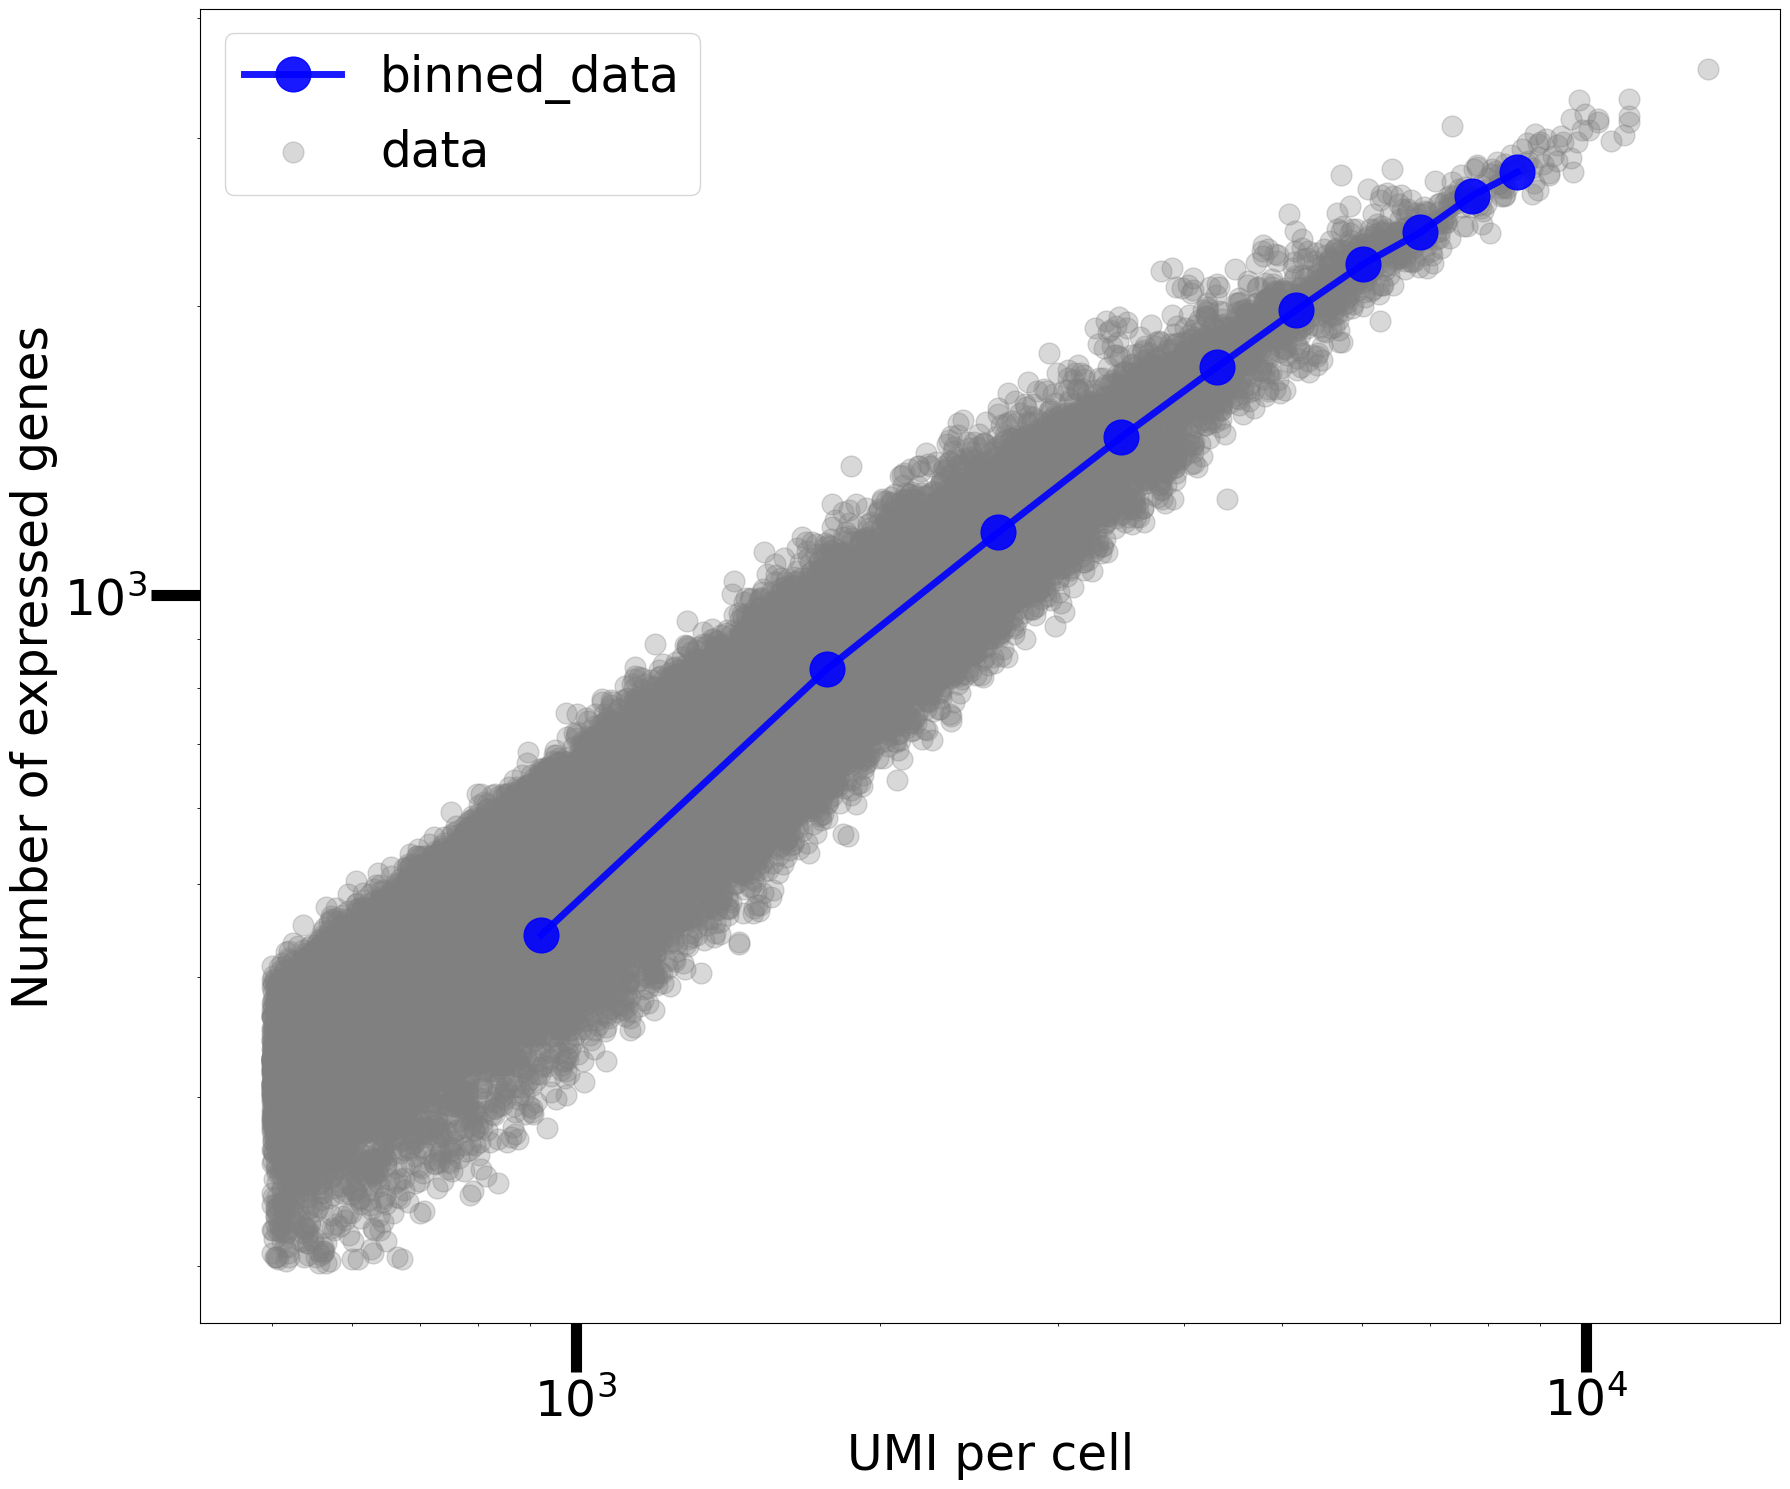

In [10]:
loglog=true

fig, ax = PyPlot.subplots(figsize=(18,15))

ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3, s=225, label="data")
bin_means, bin_edges = scipy_stats.binned_statistic(data["data"]["M"], data["data"]["diffWords"], bins=15)

x_bins = (bin_edges[1:10] + bin_edges[2:11])/2
ax.plot(x_bins, bin_means[1:10], c="blue", alpha=0.9, lw=5, ms=25, marker="o", label="binned_data")


ax.set_xlabel("UMI per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

if loglog
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.legend(fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)

PyPlot.show()
if loglog
    fig.savefig("heaps_boneMarrow_MCA_loglog.pdf")
    fig.savefig("heaps_boneMarrow_MCA_loglog.png", dpi=400)
else
    fig.savefig("heaps_boneMarrow_MCA.pdf")
    fig.savefig("heaps_boneMarrow_MCA.png", dpi=400)
end

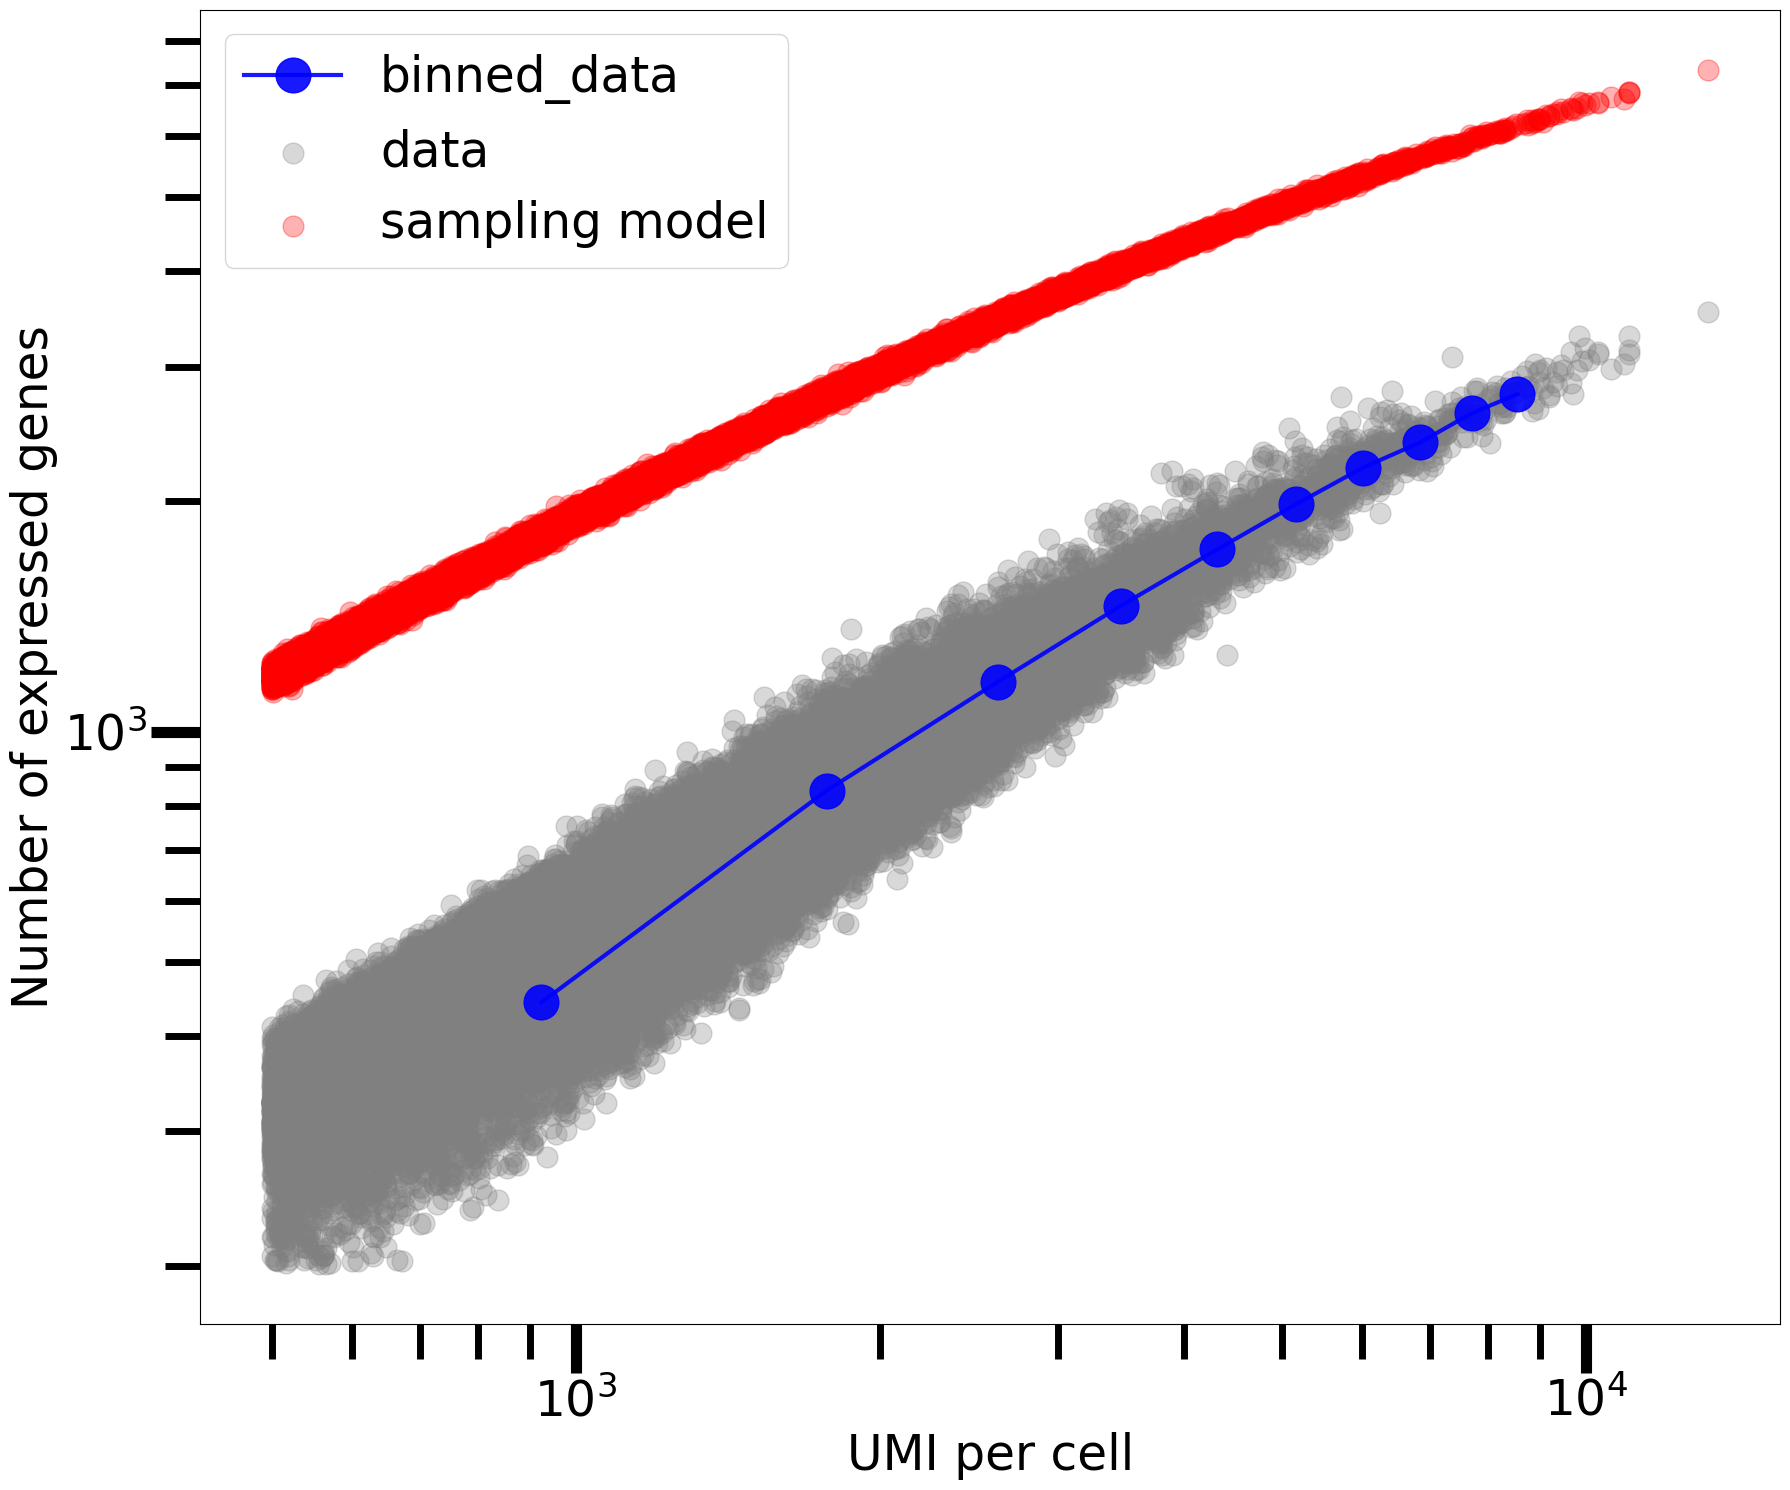

In [13]:
fig, ax = PyPlot.subplots(figsize=(18,15))

ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3, s=225, label="data")
ax.scatter(data["mazzolini"]["M"], data["mazzolini"]["diffWords"], c="red", alpha=0.3, s=225, label="sampling model")

x_bins = (bin_edges[1:10] + bin_edges[2:11])/2
ax.plot(x_bins, bin_means[1:10], c="blue", alpha=0.9, ms=25, marker="o", label="binned_data")


ax.set_xlabel("UMI per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)


if loglog
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.legend(fontsize=35)

PyPlot.show()
if loglog
    fig.savefig("heaps_boneMarrow_sampling_MCA_loglog.pdf")
    fig.savefig("heaps_boneMarrow_sampling_MCA_loglog.png", dpi=400)
else
    fig.savefig("heaps_boneMarrow_sampling_MCA.pdf")
    fig.savefig("heaps_boneMarrow_sampling_MCA.png", dpi=400)
end

# Count Zeros

In [ ]:
data = Tacos.load_pickle("mca/data_all.pkl")
data["O"].sum()*length(data["M"])

In [ ]:
1-mean(data["O"].values[data["O"].values .> 0])

In [ ]:
length(data["M"].dropna())